# Data Visualisation with Seaborn

In [19]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.ticker import ScalarFormatter
from matplotlib.ticker import FuncFormatter
import matplotlib.dates as mdates
from matplotlib.ticker import PercentFormatter
from scipy.stats import linregress
import matplotlib.ticker as mticker
from scipy.stats import linregress

In [2]:
orderlines_df = pd.read_csv('3_Data_Cleaning/data/orderlines_qc_df.csv', parse_dates=['date'])
orders_df = pd.read_csv('3_Data_Cleaning/data/orders_qc_df.csv', parse_dates=['created_date'])
products_df = pd.read_csv('3_Data_Cleaning/data/products_qc_category_df.csv')

In [3]:
orderlines_df.nunique()

id                  57974
id_order            44145
product_id              1
product_quantity       27
sku                  5722
unit_price           5627
date                57365
unit_price_total     6841
dtype: int64

## Eniac Discount Project

### Price distribution by category:

In [28]:
# 1. Compute median price per category in the desired order
category_order = (
    products_df
    .groupby('category')['price']
    .median()
    .sort_values(ascending=False)
    .index
)
medians = products_df.groupby('category')['price']\
            .median().reindex(category_order)

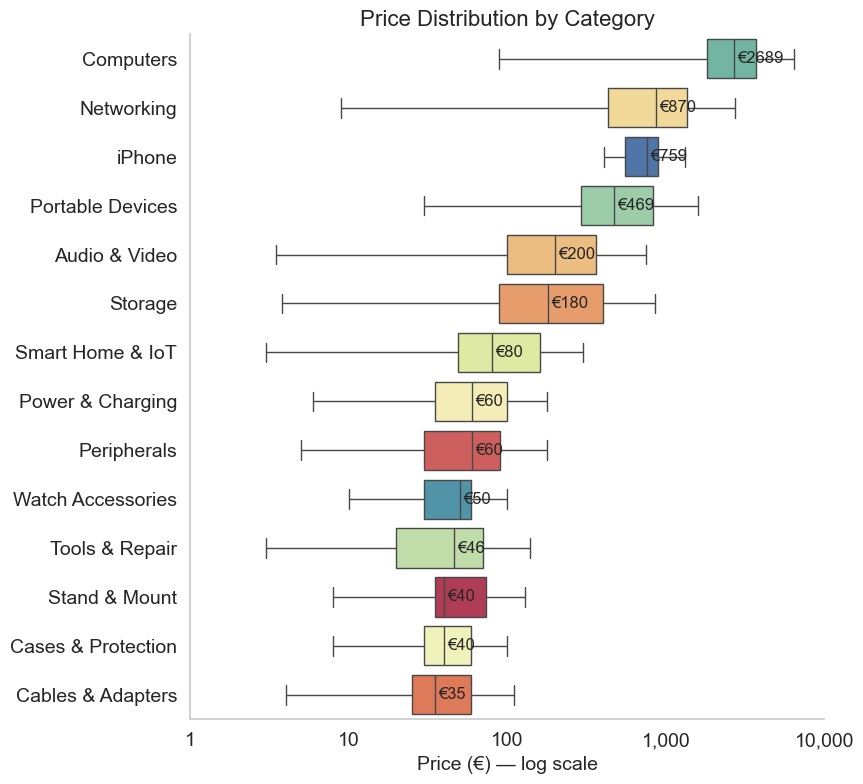

In [29]:

# 2. Draw the boxplot
sns.set_theme(style="whitegrid")
#fig, ax = plt.subplots(figsize=(8, 8))

g = sns.catplot(
    data=products_df,
    x='price',
    y='category',
    hue='category',
    kind='box',
    whis=1.5,
    height=8,
    aspect=1.1,
    palette="Spectral",
    order=category_order,
    showfliers=False
)

# 3. Grab the Axes
ax = g.ax

# 4. Remove vertical gridlines
ax.grid(False, axis='x')

# 5. Log‐scale on x (avoids zero) and clip to focus on bulk
ax.set_xscale('log')
ax.set_xlim(1, 10000)
ax.tick_params(axis='both', which='major', labelsize=14)

# 6. Switch x-axis to plain number formatting
ax.xaxis.set_major_formatter(
    FuncFormatter(lambda x, pos: f"{int(x):,}"))
ax.figure.canvas.draw()

# 7. Title and labels
ax.set_title('Price Distribution by Category', fontsize=16)
ax.set_xlabel('Price (€) — log scale', fontsize=14)
#ax.set_ylabel('Product Category', fontsize=12)
ax.set_ylabel('') 

# 8. Annotate medians
for y, cat in zip(ax.get_yticks(), medians.index):
    med = medians.loc[cat]
    ax.text(
        x=med * 1.05,
        y=y,
        s=f'€{med:.0f}',
        ha='left',
        va='center',
        fontsize=12
    )

plt.tight_layout()
plt.show()

### Category contribution

In [30]:
orderlines_product_merged_df = orderlines_df.merge(products_df, on='sku', how= 'left')
df = orderlines_product_merged_df.copy()

In [31]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 57974 entries, 0 to 57973
Data columns (total 15 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   id                57974 non-null  int64         
 1   id_order          57974 non-null  int64         
 2   product_id        57974 non-null  int64         
 3   product_quantity  57974 non-null  int64         
 4   sku               57974 non-null  object        
 5   unit_price        57974 non-null  float64       
 6   date              57974 non-null  datetime64[ns]
 7   unit_price_total  57974 non-null  float64       
 8   brand             57974 non-null  object        
 9   name              57974 non-null  object        
 10  desc              57974 non-null  object        
 11  type              57974 non-null  object        
 12  price             57974 non-null  float64       
 13  category          57974 non-null  object        
 14  subcategory       5797

In [32]:
cat_rev = (
    df
    .groupby('category')['unit_price_total']
    .sum()
    .sort_values(ascending=False)
    .reset_index()
)

# 2. Compute cumulative percentage
cat_rev['cum_revenue'] = cat_rev['unit_price_total'].cumsum()
total_rev = cat_rev['unit_price_total'].sum()
cat_rev['cum_pct'] = cat_rev['unit_price_total'] / total_rev

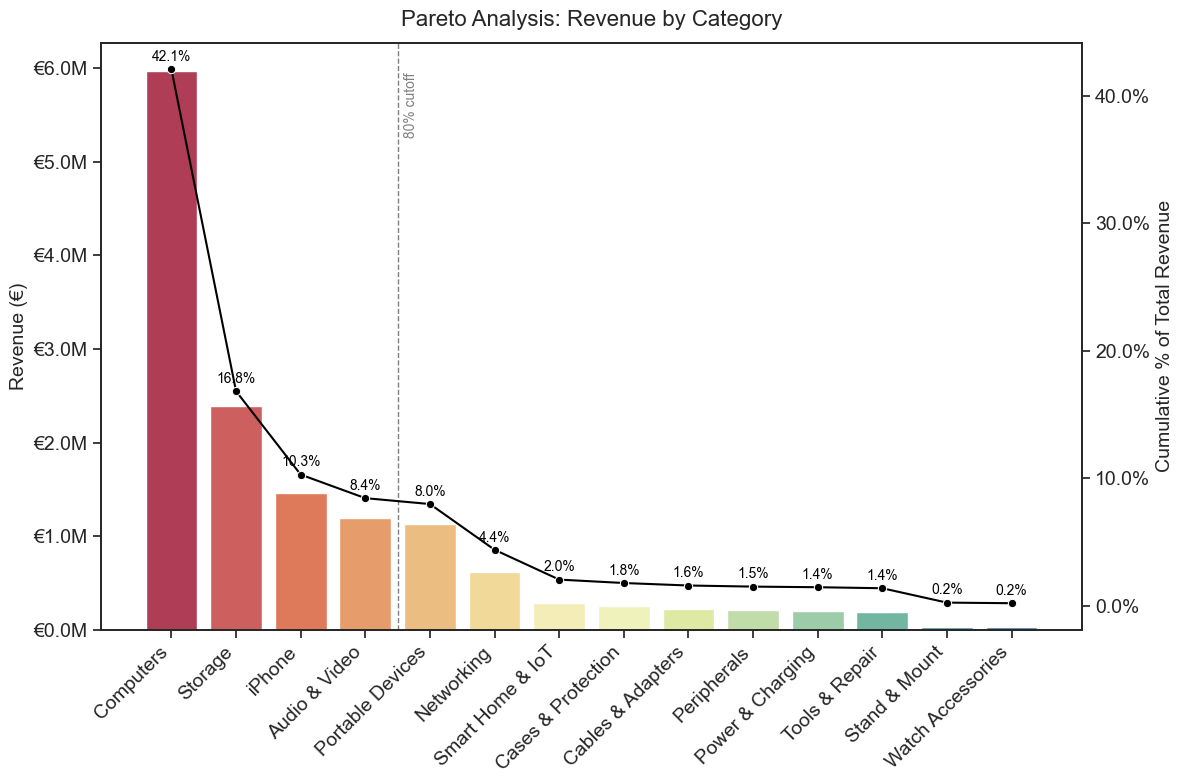

In [104]:
# 3. Plot
sns.set_style("white",                               
              {'xtick.bottom': True,                 
              }) 
fig, ax1 = plt.subplots(figsize=(12, 8))

# Bar plot: revenue by category
sns.barplot(
    data=cat_rev,
    x='category',
    y='unit_price_total',
    hue='category',
    palette='Spectral',
    ax=ax1
)
ax1.set_ylabel('Revenue (€)', fontsize=14)
ax1.yaxis.set_major_formatter(FuncFormatter(lambda x, _: f"€{x/1e6:.1f}M"))
ax1.set_xlabel('', fontsize=12)
plt.setp(ax1.get_xticklabels(), rotation=45, ha='right')
ax1.tick_params(axis='both', which='major', labelsize=14)
#ax1.set_xticklabels(ax1.get_xticklabels(), rotation=45, ha='right')

# 4. Add cumulative line on secondary axis
ax2 = ax1.twinx()
sns.lineplot(
    data=cat_rev,
    x='category',
    y='cum_pct',
    marker='o',
    color='black',
    ax=ax2
)
ax2.yaxis.set_major_formatter(PercentFormatter(xmax=1))
ax2.set_ylabel('Cumulative % of Total Revenue', fontsize=14)
ax2.tick_params(axis='both', which='major', labelsize=14)

# ——— Annotate cum% on each marker ———
for i, pct in enumerate(cat_rev['cum_pct']):
    ax2.text(
        i,                # x-position (0,1,2,…)
        pct + 0.015,       # a little above the point
        f"{pct:.1%}",     # e.g. “80%”
        ha='center', 
        va='top',
        fontsize=10,
        color='black'
    )

# find the first index where cum_pct ≥ 0.8
#threshold = 0.8
#idx = np.argmax(cat_rev['cum_pct'].values >= threshold)
idx = 3

# draw the vertical line just after that bar
# (bars are centered at integer 0,1,2…, so +0.5 moves you to the border)
ax1.axvline(x=idx + 0.5, color='gray', linestyle='--', linewidth=1)

# optional: label it
ymax = ax1.get_ylim()[1]
ax1.text(
    idx + 0.5 + 0.1,  # tiny nudge to the right
    ymax * 0.95,      # near the top of the bars
    '80% cutoff',
    rotation=90,
    va='top',
    ha='left',
    color='gray',
    fontsize=10
)

# 6. Title & layout
ax1.set_title('Pareto Analysis: Revenue by Category', fontsize=16, pad=12)
fig.tight_layout()
plt.show()

### How many products are discounted?

In [34]:
# 1a. Flag discounted vs full‐price
df['discount_flag'] = df['unit_price'] < df['price']
df['discount_label'] = df['discount_flag'].map({
    False: 'Full price',
    True:  'Discounted'
})

# 1b. Compute counts & proportions
counts = df['discount_label'].value_counts()
props  = df['discount_label'].value_counts(normalize=True)

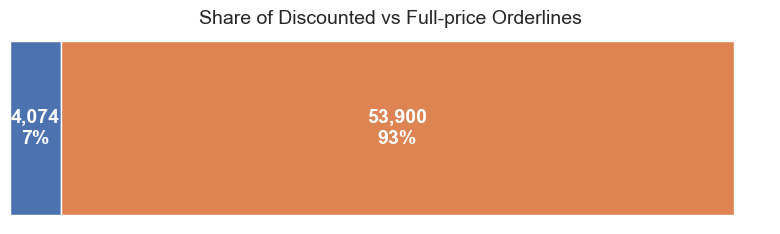

In [48]:
# ————————————————————————————————
# 2. Plot a 100% stacked horizontal bar

# Define distinct, presentation‐friendly colors
colors = {
    'Full price':"#4C72B0",   
    'Discounted':  "#DD8452"   
}

fig, ax = plt.subplots(figsize=(8, 2.5))

# Draw the segments
ax.barh(
    y=0,
    width=counts['Full price'],
    color=colors['Full price']
)
ax.barh(
    y=0,
    width=counts['Discounted'],
    left=counts['Full price'],
    color=colors['Discounted']
)

# ————————————————————————————————
# 3. Clean up axes & spines
ax.set_yticks([])           # hide y-axis
ax.set_xticks([])           # hide x-axis
for spine in ax.spines.values():
    spine.set_visible(False)

# ————————————————————————————————
# 4. Annotate each segment with count + percentage
for label in ['Full price', 'Discounted']:
    cnt = counts[label]
    pct = props[label]
    # Starting point
    start = 0 if label == 'Full price' else counts['Full price']
    center = start + cnt / 2
    ax.text(
        x=center,
        y=0,
        s=f"{cnt:,}\n{pct:.0%}",
        ha='center',
        va='center',
        color='white',
        fontsize=14,
        fontweight='bold'
    )

# ————————————————————————————————
# 5. Title
ax.set_title(
    'Share of Discounted vs Full-price Orderlines',
    fontsize=14,
    pad=6
)

plt.tight_layout()
plt.show()

### Discount depth

In [35]:
# Prepare data
df['discount_pct'] = (df['price'] - df['unit_price']) / df['price']
df = df.loc[df['discount_pct'].between(0, 1), :]

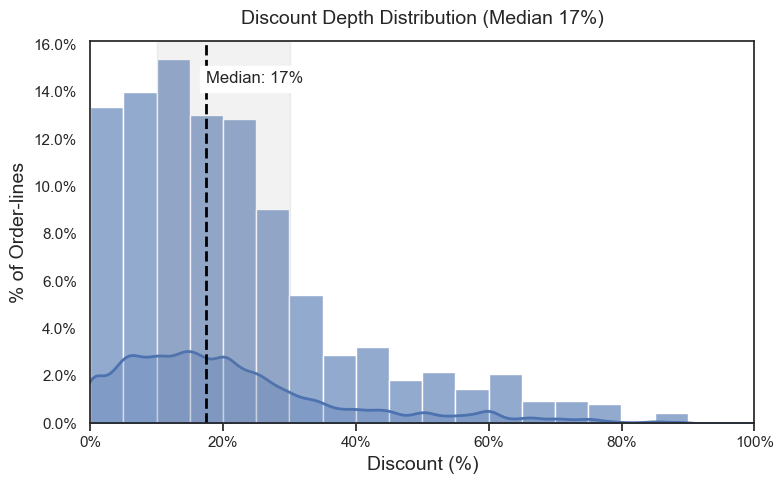

In [54]:
# Set up the figure
sns.set_style("white",                               
              {'xtick.bottom': True,                 
              }) 
plt.figure(figsize=(8, 5))

# 3. Plot histogram (percent) 
sns.histplot(
    data=df,
    x='discount_pct',
    bins=20,
    stat='percent',
    color="#4C72B0",
    alpha=0.6
)

# 4. Overlay KDE (shaded)
sns.kdeplot(
    data=df,
    x='discount_pct',
    bw_adjust=0.8,     # controls smoothing
    common_norm=False, # scale independently
    fill=True,        # fill under curve
    linewidth=2,
    color="#4C72B0"
)

ax = plt.gca()
ax.axvspan(0.1,0.3, color='grey', alpha=0.1)

# 5. Format axes as percentages
ax.set_xlim(0, 1)
ax.xaxis.set_major_formatter(PercentFormatter(xmax=1))
ax.yaxis.set_major_formatter(PercentFormatter())
ax.grid(False)
#ax.grid(color='grey', alpha=0.3)

# 6. Add median line
median = df['discount_pct'].median()
ax.axvline(median, color='black', linestyle='--', linewidth=2)
ax.text(
    median,
    ax.get_ylim()[1]*0.9,
    f"Median: {median:.0%}",
    ha='left',
    va='center',
    backgroundcolor='white'
)

# 7. Labels & title
ax.set_title('Discount Depth Distribution (Median 17%)', fontsize=14, pad=12)
ax.set_xlabel('Discount (%)', fontsize=14)
ax.set_ylabel('% of Order-lines', fontsize=14)

plt.tight_layout()
plt.show()

### Discount vs revenue over time

In [80]:
# Extract month (as timestamp at month start)
df['month'] = df['date'].dt.to_period('M').dt.to_timestamp()
df

,id,id_order,product_id,product_quantity,sku,unit_price,date,unit_price_total,brand,name,desc,type,price,category,subcategory,month,tier,revenue,discount_pct
0,1119116,299545,0,1,OWC0100,47.49,2017-01-01 01:46:16,47.49,OWC,OWC In-line Digital Temperature Sensor Kit HDD...,Kit temperature sensor for HDD iMac 21 inch an...,12755395,60.99,Tools & Repair,Replacement Part,2017-01-01,"High vol, low rev",47.49,0.221348
1,1119119,299546,0,1,IOT0014,18.99,2017-01-01 01:50:34,18.99,iOttie,iOttie Easy View 2 Car Black Support,IPhone car holder 7 plus / 7/6 Plus / 6 / 5s /...,5720,22.95,Stand & Mount,Support,2017-01-01,"Low rev, low vol",18.99,0.172549
2,1119120,295347,0,1,APP0700,72.19,2017-01-01 01:54:11,72.19,Apple,Apple 85W MagSafe 2 charger MacBook Pro screen...,Apple MagSafe 2 Charger for MacBook Pro 15-inc...,13005399,89.00,Power & Charging,Charger,2017-01-01,"Low rev, low vol",72.19,0.188876
3,1119126,299549,0,1,PAC0929,2565.99,2017-01-01 02:07:42,2565.99,Pack,"Apple iMac 27 ""Core i5 3.2GHz Retina 5K | 32GB...",IMac desktop computer 27 inch Retina 5K RAM 32...,1282,3209.00,Computers,iMac,2017-01-01,"High rev, low vol",2565.99,0.200377
4,1119134,299556,0,1,CRU0039-A,60.90,2017-01-01 02:20:14,60.90,Crucial,(Open) Crucial 240GB SSD 7mm BX200,SSD hard drive and high-speed performance with...,1298,76.99,Storage,SSD,2017-01-01,"High rev, high vol",60.90,0.208988
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
57969,1649447,527035,0,1,APP0698,9.99,2018-03-14 11:42:41,9.99,Apple,Apple Lightning Cable Connector to USB 1m Whit...,Apple Lightning USB Cable 1 meter to charge an...,1230,25.00,Cables & Adapters,Lightning USB Cable,2018-03-01,"High vol, low rev",9.99,0.600400
57970,1649512,527070,0,2,APP0698,9.99,2018-03-14 11:49:01,19.98,Apple,Apple Lightning Cable Connector to USB 1m Whit...,Apple Lightning USB Cable 1 meter to charge an...,1230,25.00,Cables & Adapters,Lightning USB Cable,2018-03-01,"High vol, low rev",19.98,0.600400
57971,1649522,527074,0,2,APP0698,9.99,2018-03-14 11:49:36,19.98,Apple,Apple Lightning Cable Connector to USB 1m Whit...,Apple Lightning USB Cable 1 meter to charge an...,1230,25.00,Cables & Adapters,Lightning USB Cable,2018-03-01,"High vol, low rev",19.98,0.600400
57972,1649565,527096,0,3,APP0698,9.99,2018-03-14 11:54:35,29.97,Apple,Apple Lightning Cable Connector to USB 1m Whit...,Apple Lightning USB Cable 1 meter to charge an...,1230,25.00,Cables & Adapters,Lightning USB Cable,2018-03-01,"High vol, low rev",29.97,0.600400


In [81]:
# Aggregate to monthly level
monthly = (
    df
    .groupby('month')
    .agg(
        revenue=('unit_price_total', 'sum'),
        discount_pct=('discount_pct', 'mean')
    )
    .reset_index()
)

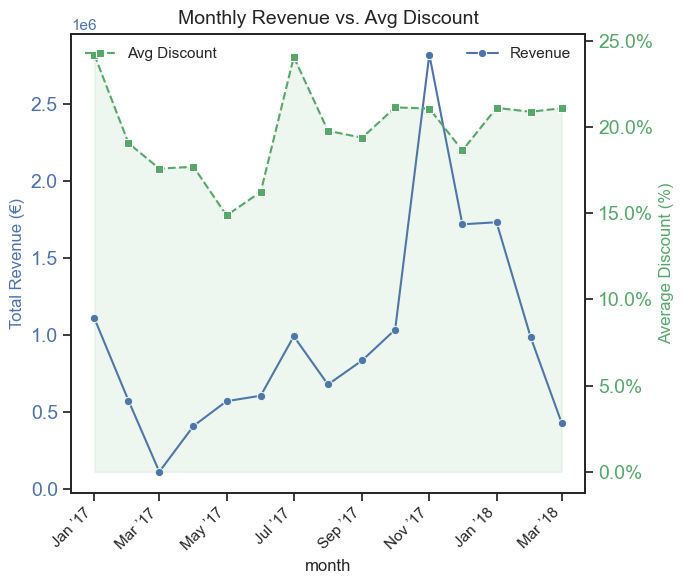

In [82]:
# Plot with dual‐axes
sns.set_style("white",                               
              {'xtick.bottom': True,                 
              }) 
fig, ax1 = plt.subplots(figsize=(7, 6))

# Revenue line
h1 = sns.lineplot(
    data=monthly, x='month', y='revenue',
    marker='o', ax=ax1, color="#4C72B0", label='Revenue'
)
ax1.set_ylabel('Total Revenue (€)', color="#4C72B0")
ax1.tick_params(axis='y', labelcolor="#4C72B0", labelsize=14)

# Discount line + fill
ax2 = ax1.twinx()
h2 = sns.lineplot(
    data=monthly, x='month', y='discount_pct',
    marker='s', linestyle='--', ax=ax2,
    color="#55A868", label='Avg Discount'
)
ax2.fill_between(
    monthly['month'],
    monthly['discount_pct'],
    color="#55A868", alpha=0.1
)
ax2.set_ylabel('Average Discount (%)', color="#55A868")
ax2.yaxis.set_major_formatter(PercentFormatter(xmax=1))
ax2.tick_params(axis='y', labelcolor="#55A868", labelsize=14)

# Date formatting
ax1.xaxis.set_major_formatter(mdates.DateFormatter("%b ’%y"))
for lbl in ax1.get_xticklabels():
    lbl.set_rotation(45)
    lbl.set_ha('right')

# Manual legends
h1_handles, h1_labels = ax1.get_legend_handles_labels()
h2_handles, h2_labels = ax2.get_legend_handles_labels()
ax1.legend(h1_handles, h1_labels, loc='upper right', frameon=False)
ax2.legend(h2_handles, h2_labels, loc='upper left', frameon=False)

# Title & layout
ax1.set_title('Monthly Revenue vs. Avg Discount', fontsize=14, pad=7)
fig.tight_layout()
plt.show()


### Seasonality (Black Friday/Christmas)

In [52]:
df

,id,id_order,product_id,product_quantity,sku,unit_price,date,unit_price_total,brand,name,desc,type,price,category,subcategory,discount_flag,discount_label,discount_pct,month
0,1119116,299545,0,1,OWC0100,47.49,2017-01-01 01:46:16,47.49,OWC,OWC In-line Digital Temperature Sensor Kit HDD...,Kit temperature sensor for HDD iMac 21 inch an...,12755395,60.99,Tools & Repair,Replacement Part,True,Discounted,0.221348,2017-01-01
1,1119119,299546,0,1,IOT0014,18.99,2017-01-01 01:50:34,18.99,iOttie,iOttie Easy View 2 Car Black Support,IPhone car holder 7 plus / 7/6 Plus / 6 / 5s /...,5720,22.95,Stand & Mount,Support,True,Discounted,0.172549,2017-01-01
2,1119120,295347,0,1,APP0700,72.19,2017-01-01 01:54:11,72.19,Apple,Apple 85W MagSafe 2 charger MacBook Pro screen...,Apple MagSafe 2 Charger for MacBook Pro 15-inc...,13005399,89.00,Power & Charging,Charger,True,Discounted,0.188876,2017-01-01
3,1119126,299549,0,1,PAC0929,2565.99,2017-01-01 02:07:42,2565.99,Pack,"Apple iMac 27 ""Core i5 3.2GHz Retina 5K | 32GB...",IMac desktop computer 27 inch Retina 5K RAM 32...,1282,3209.00,Computers,iMac,True,Discounted,0.200377,2017-01-01
4,1119134,299556,0,1,CRU0039-A,60.90,2017-01-01 02:20:14,60.90,Crucial,(Open) Crucial 240GB SSD 7mm BX200,SSD hard drive and high-speed performance with...,1298,76.99,Storage,SSD,True,Discounted,0.208988,2017-01-01
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
57969,1649447,527035,0,1,APP0698,9.99,2018-03-14 11:42:41,9.99,Apple,Apple Lightning Cable Connector to USB 1m Whit...,Apple Lightning USB Cable 1 meter to charge an...,1230,25.00,Cables & Adapters,Lightning USB Cable,True,Discounted,0.600400,2018-03-01
57970,1649512,527070,0,2,APP0698,9.99,2018-03-14 11:49:01,19.98,Apple,Apple Lightning Cable Connector to USB 1m Whit...,Apple Lightning USB Cable 1 meter to charge an...,1230,25.00,Cables & Adapters,Lightning USB Cable,True,Discounted,0.600400,2018-03-01
57971,1649522,527074,0,2,APP0698,9.99,2018-03-14 11:49:36,19.98,Apple,Apple Lightning Cable Connector to USB 1m Whit...,Apple Lightning USB Cable 1 meter to charge an...,1230,25.00,Cables & Adapters,Lightning USB Cable,True,Discounted,0.600400,2018-03-01
57972,1649565,527096,0,3,APP0698,9.99,2018-03-14 11:54:35,29.97,Apple,Apple Lightning Cable Connector to USB 1m Whit...,Apple Lightning USB Cable 1 meter to charge an...,1230,25.00,Cables & Adapters,Lightning USB Cable,True,Discounted,0.600400,2018-03-01


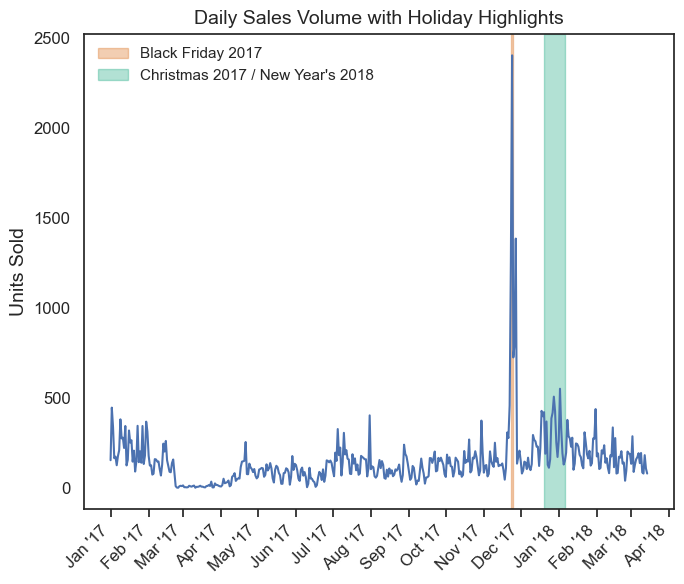

In [78]:
daily = (
    df
    .set_index('date')
    .resample('D')['product_quantity']
    .sum()
    .reset_index()
)

# 2. Plot daily volume
sns.set_style("white", {'xtick.bottom': True})
fig, ax = plt.subplots(figsize=(7, 6))

sns.lineplot(
    data=daily,
    x='date',
    y='product_quantity',
    ax=ax,
    color="#4C72B0",
    linewidth=1.5
)

# 3. Highlight Black Friday & Christmas windows
bf = pd.to_datetime("2017-11-24")
xmas_start = pd.to_datetime("2017-12-20")
xmas_end   = pd.to_datetime("2018-01-06")

ax.axvspan(
    bf - pd.Timedelta(days=1),
    bf + pd.Timedelta(days=1),
    color="#D55E00", alpha=0.3,
    label="Black Friday 2017"
)
ax.axvspan(
    xmas_start,
    xmas_end,
    color="#009E73", alpha=0.3,
    label="Christmas 2017 / New Year's 2018"
)

# 4. Formatting
ax.set_title("Daily Sales Volume with Holiday Highlights", fontsize=14, pad=7)
ax.set_xlabel("") 
ax.set_ylabel("Units Sold", fontsize=14)
ax.tick_params(axis='both', which='major', labelsize=12)

# monthly ticks
ax.xaxis.set_major_locator(mdates.MonthLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter("%b '%y"))
plt.setp(ax.get_xticklabels(), rotation=45, ha='right')

# 5. Legend
ax.legend(loc="upper left", frameon=False)

plt.tight_layout()
plt.show()


### Correlation view

In [93]:
# Compute regression statistics
slope, intercept, r_value, p_value, stderr = linregress(
    monthly['discount_pct'], monthly['revenue']
)

# Identify holiday months (Nov & Dec) for highlighting
monthly['month_type'] = monthly['month'].dt.month.isin([11, 12]) \
    .map({True: 'Holiday (Nov/Dec)', False: 'Other months'})

palette = {
    'Other months': '#4C72B0',
    'Holiday (Nov/Dec)': '#D55E00'
}
sizes = {
    'Other months': 60,
    'Holiday (Nov/Dec)': 120
}

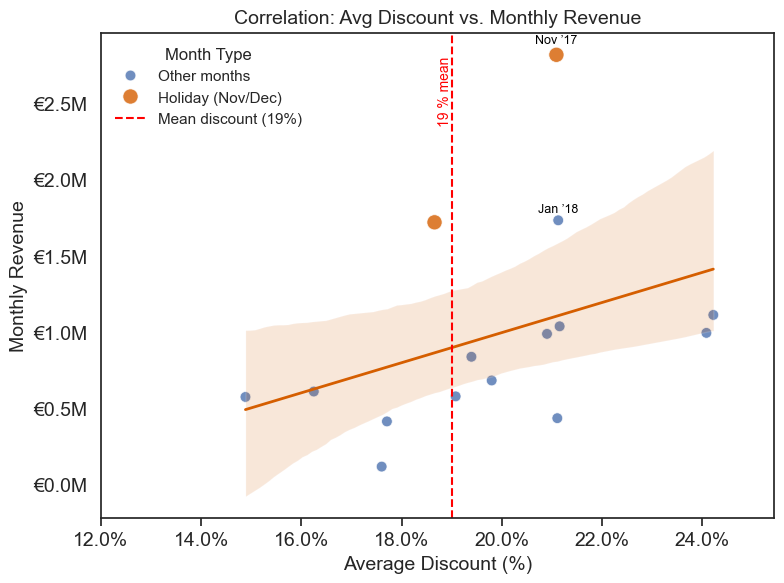

In [94]:
# Plot
sns.set_style("white",                               
              {'xtick.bottom': True,                 
              }) 
fig, ax = plt.subplots(figsize=(8, 6))

# Scatter: highlighted by month_type
sns.scatterplot(
    data=monthly,
    x='discount_pct',
    y='revenue',
    hue='month_type',
    palette=palette,
    size='month_type',
    sizes=sizes,
    alpha=0.8,
    ax=ax,
    legend='brief'
)

# Regression line (no scatter)
sns.regplot(
    data=monthly,
    x='discount_pct',
    y='revenue',
    scatter=False,
    ax=ax,
    color='#D55E00',
    line_kws={'linewidth': 2},
    ci=95,
    truncate=True
)

mean_discount = 0.19        # 19 %
ax.axvline(
    x=mean_discount,
    color='red',
    linestyle='--',
    linewidth=1.5,
    label='Mean discount (19%)'
)
# optional label near the top
ax.text(
    mean_discount, ax.get_ylim()[1]*0.95,
    "19 % mean",
    rotation=90,
    color='red',
    va='top', ha='right',
    fontsize=10
)

# 5. Annotate r and p in the top-left
# ax.text(
#     0.05, 0.95,
#     f"$r$ = {r_value:.2f}, p = {p_value:.3f}",
#     transform=ax.transAxes,
#     ha='right', va='bottom',
#     fontsize=11,
#     bbox=dict(boxstyle="round,pad=0.3", facecolor="white", edgecolor="gray")
# )

# 6. Label the two highest-revenue points
top2 = monthly.nlargest(2, 'revenue')
for _, row in top2.iterrows():
    ax.text(
        row['discount_pct'],
        row['revenue'] * 1.02,
        row['month'].strftime("%b ’%y"),
        ha='center', va='bottom',
        fontsize=9,
        color='black'
    )

# 7. Grid and axis formatting
ax.grid(axis='y', alpha=0.3)
ax.grid(False)
#ax.grid(axis='x', False)

ax.set_xlim(0.12, monthly['discount_pct'].max() * 1.05)
ax.xaxis.set_major_formatter(PercentFormatter(xmax=1))
ax.yaxis.set_major_formatter(FuncFormatter(lambda x, pos: f"€{x/1e6:.1f}M"))
ax.tick_params(axis='both', which='major', labelsize=14)

# 8. Titles & labels
ax.set_title('Correlation: Avg Discount vs. Monthly Revenue', fontsize=14, pad=7)
ax.set_xlabel('Average Discount (%)', fontsize=14)
ax.set_ylabel('Monthly Revenue', fontsize=14)

# 9. Legend adjustments
ax.legend(
    title='Month Type',
    loc='upper left',
    frameon=False
)

plt.tight_layout()
plt.show()


In [59]:

# 1. Ensure datetime & compute month-period
df = orderlines_product_merged_df.copy()
df['date'] = pd.to_datetime(df['date'])
df['month']      = df['date'].dt.to_period('M').dt.to_timestamp()

# 2. Compute per-line revenue & make sure discount_pct exists
df['revenue']     = df['unit_price'] * df['product_quantity']
df['discount_pct'] = (df['price'] - df['unit_price']) / df['price']

# 3. Aggregate to monthly-level
monthly = (
    df
    .groupby('month')
    .agg(
        avg_discount   = ('discount_pct', 'mean'),
        total_revenue  = ('revenue',     'sum'),
        total_units    = ('product_quantity',    'sum'),
    )
    .reset_index()
)

# 4. Bucket into Low vs High discount
threshold = 0.20  # 17%
monthly['discount_bucket'] = monthly['avg_discount'].apply(
    lambda x: 'Low (≤ 20%)' if x <= threshold else 'High (> 20%)'
)

# 5. Summarize by bucket
summary = (
    monthly
    .groupby('discount_bucket')
    .agg(
        **{
            'Avg Revenue / Month (€M)': ('total_revenue', lambda s: s.mean() / 1e6),
            'Avg Units / Month (k)':    ('total_units',   lambda s: s.mean() / 1e3),
            'Months in Bucket':         ('month',         'count'),
        }
    )
    .round(2)
    .reset_index()
)

# 6. Pretty-print
print(summary.to_string(index=False))


discount_bucket  Avg Revenue / Month (€M)  Avg Units / Month (k)  Months in Bucket
   High (> 20%)                      1.30                   5.81                 7
    Low (≤ 20%)                      0.69                   3.04                 8


1. Map categories → tiers

In [ ]:
# your merged order‐lines DF
df = orderlines_product_merged_df.copy()
df['date'] = pd.to_datetime(df['date'])
df['month']      = df['date'].dt.to_period('M').dt.to_timestamp()

# define your tiers
tier_map = {
    # High revenue / high volume
    'Storage':              'High rev, high vol',
    'Audio & Video':        'High rev, high vol',
    # High revenue / low volume
    'Computers':            'High rev, low vol',
    'iPhone':               'High rev, low vol',
    'Portable Devices':     'High rev, low vol',
    'Networking':           'High rev, low vol',
    # High volume / low revenue
    'Cases & Protection':   'High vol, low rev',
    'Cables & Adapters':    'High vol, low rev',
    'Tools & Repair':       'High vol, low rev',
    'Smart Home & IoT':     'High vol, low rev',
    # Low revenue / low volume
    'Stand & Mount':         'Low rev, low vol',
    'Watch Accessories':     'Low rev, low vol',
    'Peripherals':           'Low rev, low vol',
    'Power & Charging':      'Low rev, low vol',
}

df['tier'] = df['category'].map(tier_map)
df = df.dropna(subset=['tier'])  # keep only those 3 tiers


2. Build monthly‐by‐tier summary

In [75]:
# compute line‐level metrics
df['revenue']     = df['unit_price'] * df['product_quantity']
df['discount_pct'] = (df['price'] - df['unit_price']) / df['price']

monthly_tier = (
    df
    .groupby(['tier','month'])
    .agg(
        total_revenue = ('revenue', 'sum'),
        avg_discount  = ('discount_pct', 'mean')
    )
    .reset_index()
)


3. Scatter + regplot faceted by tier

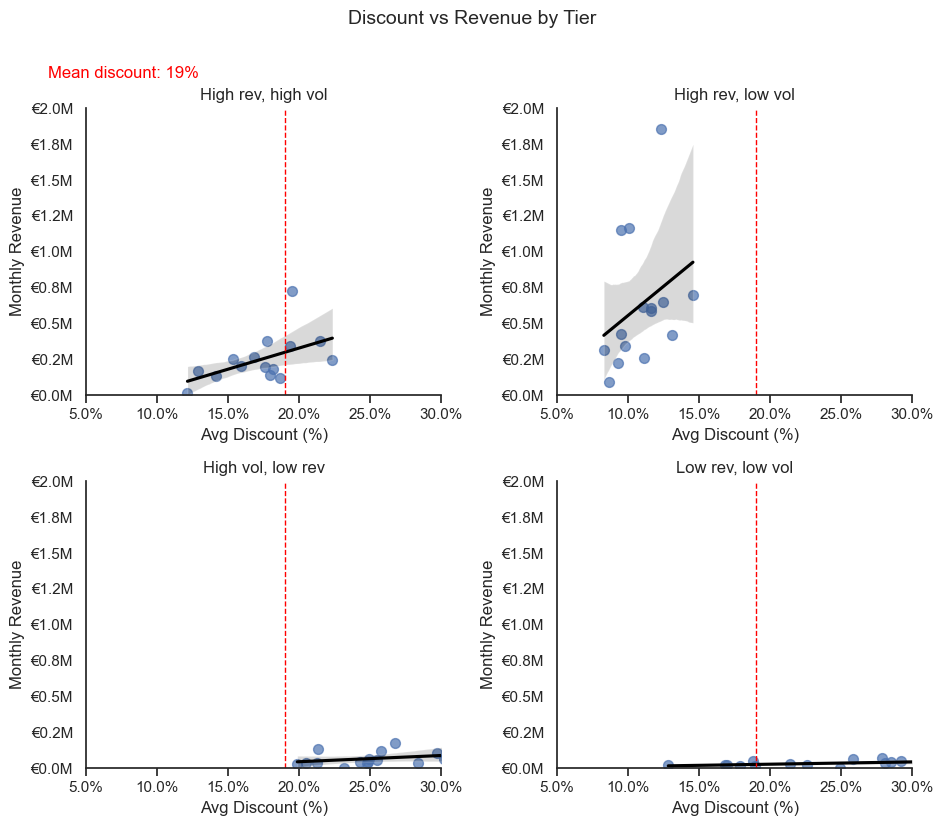

In [76]:
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.ticker import PercentFormatter

# 1. Compute the global avg discount
global_avg = monthly_tier['avg_discount'].mean()

sns.set_style("white",                               
              {'xtick.bottom': True,                 
              }) 

# lmplot will draw regression + scatter in three panels
g = sns.lmplot(
    data=monthly_tier,
    x='avg_discount',
    y='total_revenue',
    col='tier',
    col_wrap=2,                  # <-- wrap into 2 columns
    height=4,
    aspect=1.2,
    scatter_kws={'s':50, 'alpha':0.7},
    line_kws={'color':'black'},
    facet_kws={'sharex': False, 'sharey': False}
)

# Format each axis
for ax in g.axes.flat:
    # vertical at mean discount
    ax.axvline(
        global_avg,
        color='red',
        linestyle='--',
        linewidth=1
    )
    
    # axis formatting
    ax.xaxis.set_major_formatter(PercentFormatter(xmax=1))
    ax.yaxis.set_major_formatter(lambda x, pos: f"€{x/1e6:.1f}M")
    ax.set_xlabel("Avg Discount (%)")
    ax.set_ylabel("Monthly Revenue")
    ax.set_title(ax.get_title().split('=')[1].strip())

# 4. Global limits & title
g.set(xlim=(0.05, 0.30), ylim=(0, 2e6))
g.fig.suptitle("Discount vs Revenue by Tier", y=1.03, fontsize=14)
g.tight_layout()

# 5. Annotate the mean line once in the top‐left
plt.annotate(
    f"Mean discount: {global_avg:.0%}",
    xy=(0.05, 0.95),
    xycoords='figure fraction',
    color='red',
    fontsize=12,
    ha='left', va='top'
)

plt.show()


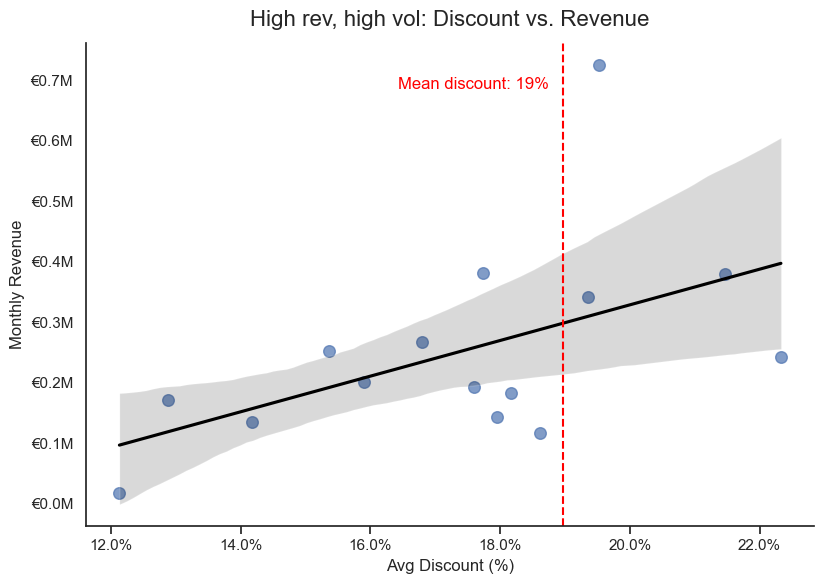

In [91]:
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.ticker import PercentFormatter, FuncFormatter

# 1. Filter to your target tier
df_hrhv = monthly_tier.loc[
    monthly_tier['tier'] == 'High rev, high vol'
].copy()

# 2. Compute the global average discount if you still want that reference line
global_avg = monthly_tier['avg_discount'].mean()

# 3. Plot
sns.set_style("white", {'xtick.bottom': True})
g = sns.lmplot(
    data=df_hrhv,
    x='avg_discount',
    y='total_revenue',
    height=6,
    aspect=1.4,
    scatter_kws={'s':70, 'alpha':0.7},
    line_kws={'color':'black'},
    facet_kws={'sharex': False, 'sharey': False}
)

ax = g.ax

# 4. Reference line at global mean
ax.axvline(global_avg, color='red', linestyle='--')

# 5. Formatting
ax.xaxis.set_major_formatter(PercentFormatter(xmax=1))
ax.yaxis.set_major_formatter(FuncFormatter(lambda x, pos: f"€{x/1e6:.1f}M"))
ax.set_xlabel("Avg Discount (%)")
ax.set_ylabel("Monthly Revenue")
ax.set_title("High rev, high vol: Discount vs. Revenue", fontsize=16, pad=12)

# 6. Annotate mean
ax.annotate(
    f"Mean discount: {global_avg:.0%}",
    xy=(global_avg, ax.get_ylim()[1]*0.9),
    xytext=(-10,0), textcoords='offset points',
    color='red', fontsize=12, ha='right'
)

plt.tight_layout()
plt.show()


### Total Quantity by Category, rank

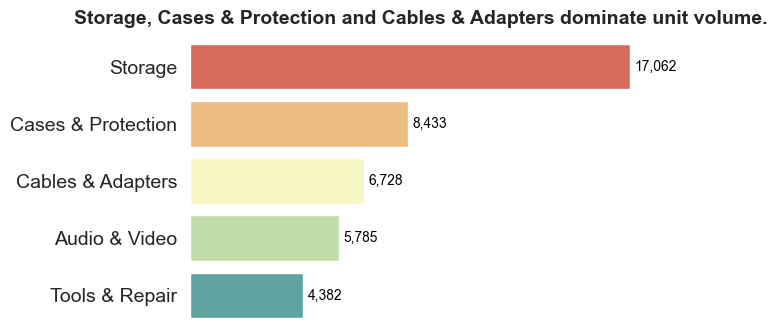

In [103]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.ticker import StrMethodFormatter

# ── 1. Aggregate volume by category ────────────────────────────────
df = orderlines_product_merged_df.copy()          # your merged DataFrame
top5 = (
    df.groupby('category')['product_quantity']
      .sum()
      .sort_values(ascending=False)
      .head(5)
      .reset_index()
)

# ── 2. Build a custom color palette (Spectral, 5 colours) ─────────
palette = sns.color_palette("Spectral", n_colors=5)

# ── 3. Plot ────────────────────────────────────────────────────────
sns.set_style("white", 
              #{'xtick.bottom': True}
              )
fig, ax = plt.subplots(figsize=(7, 3.5))

sns.barplot(
    data=top5,
    y='category',
    x='product_quantity',
    hue = 'category',
    palette=palette,
    ax=ax
)

ax.tick_params(axis='both', which='major', labelsize=14)

# ── 4. Annotate each bar with the value ───────────────────────────
for idx, row in top5.iterrows():
    ax.text(
        row['product_quantity'] + max(top5['product_quantity']) * 0.01,  # small offset
        idx,
        f"{row['product_quantity']:,}",
        va='center',
        ha='left',
        fontsize=10,
        color='black'
    )

# ── 5. Formatting ─────────────────────────────────────────────────
ax.set_title("Storage, Cases & Protection and Cables & Adapters dominate unit volume.", fontsize=14, pad=10, weight='bold')
ax.set_xlabel("")            # ← remove x-axis title
ax.set_ylabel("")            # y-axis title not needed
ax.set_xticks([])            # ← hide ticks / numbers entirely
sns.despine(left=True, bottom=True)

plt.tight_layout()
plt.show()


### Discount by Category, rank

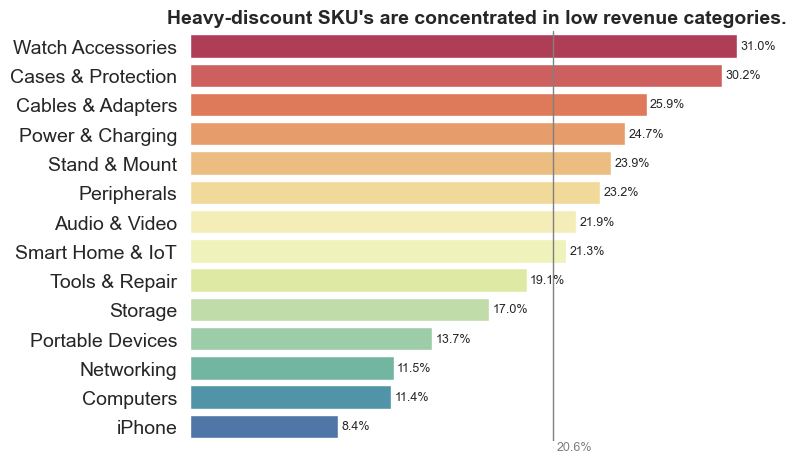

In [109]:
# ── 1.  Compute mean discount per category ────────────────────────
df = orderlines_product_merged_df.copy()
df['discount_pct'] = (df['price'] - df['unit_price']) / df['price']

cat_disc = (
    df.groupby('category')['discount_pct']
      .mean()
      .sort_values(ascending=False)
      .reset_index()
)

# overall mean for the vertical reference line
global_avg = df['discount_pct'].mean()

# ── 2.  Build colour palette (Spectral, reversed so highest = deep red) ───
palette = sns.color_palette("Spectral", len(cat_disc))

# ── 3.  Plot horizontal bars ───────────────────────────────────────
sns.set_theme(style="white")
fig, ax = plt.subplots(figsize=(8, 4.8))

sns.barplot(
    data=cat_disc,
    y='category',
    x='discount_pct',
    hue = 'category',
    palette=palette,
    ax=ax
)

ax.tick_params(axis='both', which='major', labelsize=14)

# ── 4.  Annotate each bar with its % discount ─────────────────────
for i, pct in enumerate(cat_disc['discount_pct']):
    ax.text(
        pct + 0.002,               # nudge to right of bar
        i,
        f"{pct:.1%}",
        va='center',
        ha='left',
        fontsize=9
    )

# ── 5.  Add vertical reference line at global mean ────────────────
ax.axvline(global_avg, color='gray', linewidth=1)
ax.text(
    global_avg + 0.002,
    len(cat_disc) - 0.5,
    f"{global_avg:.1%}",
    rotation=0,
    va='top',
    ha='left',
    color='gray',
    fontsize=9
)

# ── 6.  Formatting & clean-up ─────────────────────────────────────
ax.set_title("Heavy-discount SKU's are concentrated in low revenue categories.", fontsize=14, weight='bold', pad=6)
ax.set_xlabel("")           # hide x-axis label
ax.set_ylabel("")
ax.set_xticks([])           # remove tick labels – bars are labelled
ax.xaxis.set_major_formatter(PercentFormatter(1))   # keep % formatter in case you keep ticks
sns.despine(left=True, bottom=True)

plt.tight_layout()
plt.show()
